# General import functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import scanpy.api as sc
from igraph import *
from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_csv
sc.logging.print_versions()

scanpy==1.4.3+60.gb3dc34a anndata==0.6.22rc1 umap==0.3.9 numpy==1.16.4 scipy==1.3.0 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.10.0rc2 python-igraph==0.7.1 louvain==0.6.1


In [2]:
pwd

'/home/ubuntu/maca-data-analysis/sapiens'

# Load the data

In [3]:
tissue = 'Bladder'

In [4]:
tiss_facs = read_h5ad('/maca-bulk/sapiens/tabula-sapiens-facs-pilot-filtered-Blood.h5ad')
tiss_droplet = read_h5ad('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-blood.h5ad')
tiss_facs, tiss_droplet


(AnnData object with n_obs × n_vars = 277 × 24697 
     obs: 'plate', 'well', 'tissue', 'primary_sort', 'anatomical_position', 'sort_order', 'well_group', 'excluded', 'sort_direction', 'investigator', 'barcode', 'cDNA_prep_person', 'cDNA_dilute', 'library_prep', 'lib_prep_date', 'bead_cleanup', 'BA_nM', 'NovaSeqRun', 'additional_notes', 'n_genes'
     var: 'n_cells', AnnData object with n_obs × n_vars = 9283 × 21380 
     obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid', 'n_genes'
     var: 'n_cells')

In [ ]:
bladder_louvain_cell_ontology_droplet = {}
bladder_louvain_cell_ontology_droplet['0'] = ...
bladder_louvain_cell_ontology_droplet

In [ ]:
tiss.obs['cell_ontology_class'] = tiss.obs['louvain'].map(bladder_louvain_cell_ontology_droplet)
set(tiss.obs['cell_ontology_class'])

# Load the data

In [ ]:
adata

In [ ]:
set(adata.obs['tissue'])

Filter out cells with less than 200 genes detected and genes expressed in less than 3 cells

In [ ]:
adata

save the filtered data

In [ ]:
adata.write('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered.h5ad')

# Annotate the DROPLET data

In [44]:
tiss_droplet = read_h5ad('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-blood.h5ad')

adata = tiss_droplet
adata

AnnData object with n_obs × n_vars = 9283 × 21380 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid', 'n_genes'
    var: 'n_cells'

In [45]:
igg_genes = adata.var_names[adata.var_names.str.startswith('IGH')]
igg_genes

Index(['IGHMBP2'], dtype='object', name='index')

In [46]:
ercc_genes = adata.var_names[adata.var_names.str.startswith('ERCC-')]
ercc_genes

Index([], dtype='object', name='index')

In [47]:
adata = adata[:,~adata.var_names.isin(ercc_genes)]
adata

View of AnnData object with n_obs × n_vars = 9283 × 21380 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid', 'n_genes'
    var: 'n_cells'

In [48]:
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_cells(adata, min_counts=2000)
sc.pp.filter_genes(adata, min_cells=3)

Trying to set attribute `.obs` of view, making a copy.


In [49]:
set(adata.obs['tissue'])

{'blood'}

Compute the nUMIS (using 'n_counts' as generic column name)

In [50]:
adata.obs['n_counts'] = adata.X.sum(axis=1)#.A1

Look at the overall distribution of the data

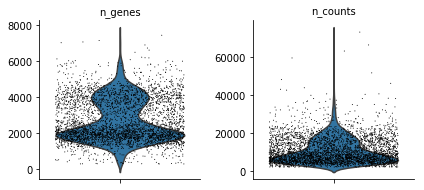

In [51]:
sc.pl.violin(adata, ['n_genes', 'n_counts'],jitter=0.4, multi_panel=True)

/home/ubuntu/maca-data-analysis/scanpy/scanpy/plotting/_anndata.py:318: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1469: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/ubuntu/maca-data-analysis/scanpy/scanpy/plotting/_anndata.py:319: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1469: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


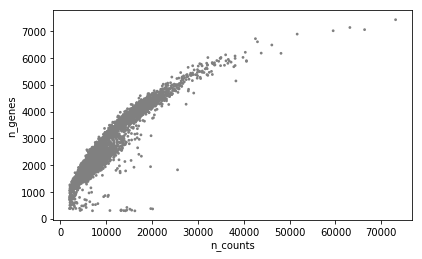

In [52]:
sc.pl.scatter(adata, x='n_counts', y='n_genes')

Because we're doing first exploratory pass let's remove cells that have more than 5000 genes given that those have higher chances of being doublets

In [53]:
#adata = adata[adata.obs['n_genes'] < 5000, :]

In [54]:
adata

AnnData object with n_obs × n_vars = 3865 × 16185 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid', 'n_genes', 'n_counts'
    var: 'n_cells'

Following the standard pipeline, next we normalize, log, compute highly variable genes and scale

In [55]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [56]:
sc.pp.log1p(adata)


In [57]:
adata.raw = adata

In [58]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

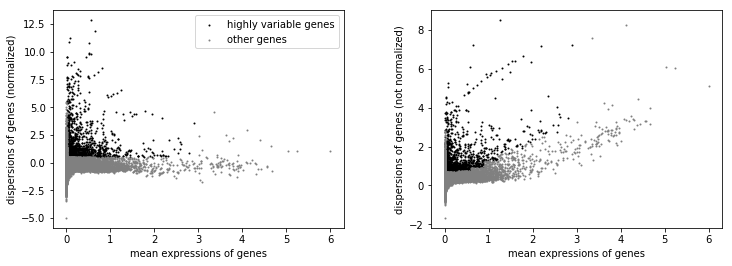

In [59]:
sc.pl.highly_variable_genes(adata)


In [60]:
adata


AnnData object with n_obs × n_vars = 3865 × 16185 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid', 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [61]:
sc.pp.scale(adata, max_value=10)


Next we compute PCA

In [62]:
sc.tl.pca(adata, svd_solver='arpack')


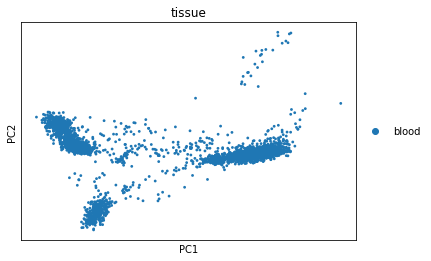

In [63]:
sc.pl.pca(adata, color='tissue')


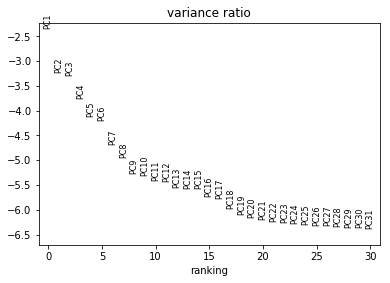

In [64]:
sc.pl.pca_variance_ratio(adata, log=True)


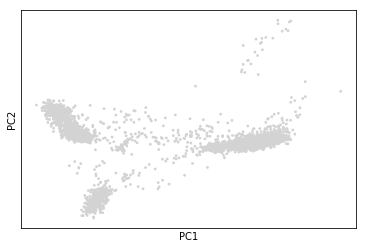

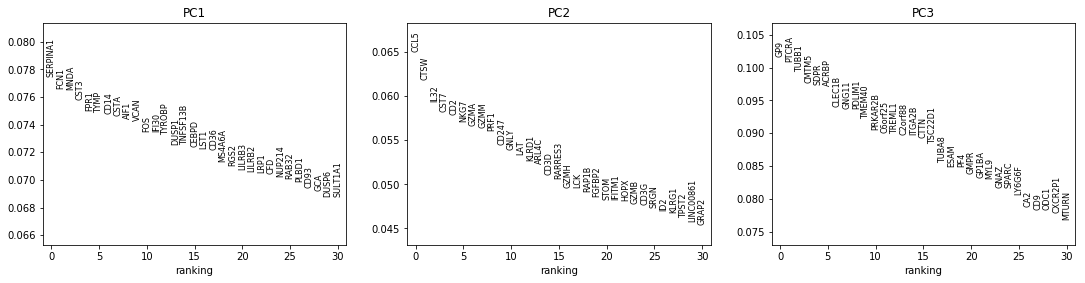

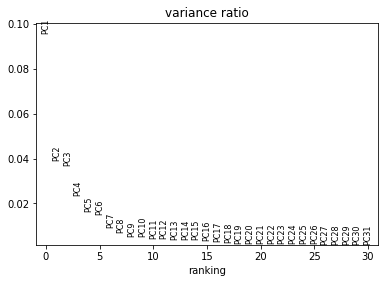

In [65]:
sc.pl.pca_overview(adata)

Now we're ready to start fishing out some structure in the data

In [66]:
sc.pp.neighbors(adata, n_neighbors=12, n_pcs=9)


In [67]:
sc.tl.louvain(adata)
sc.tl.leiden(adata)

In [68]:
sc.tl.umap(adata)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


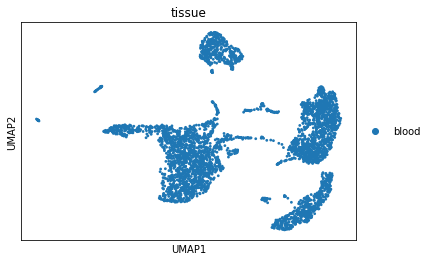

In [69]:
# sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['tissue'])

In [70]:
set(adata.obs['tissue'])

{'blood'}

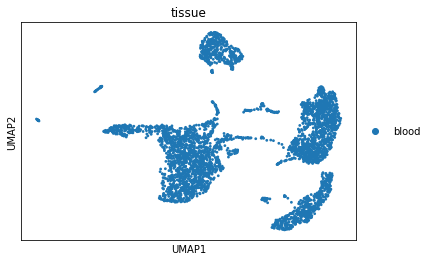

In [71]:
sc.pl.umap(adata, color=['tissue'],use_raw=False)

Let's take a look at one tissue as e.g. for batch effect...

In [72]:
adata.obs.columns

Index(['10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid', 'n_genes',
       'n_counts', 'louvain', 'leiden'],
      dtype='object')

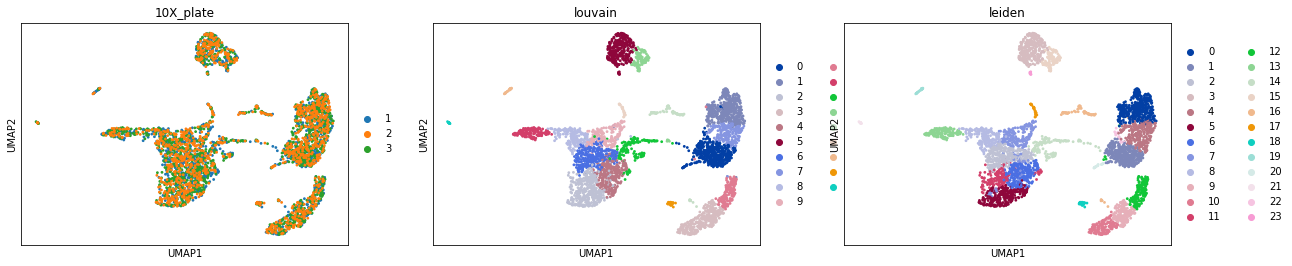

In [73]:
sc.pl.umap(adata, color=['10X_plate','louvain','leiden'])

Looking good! Into clustering...

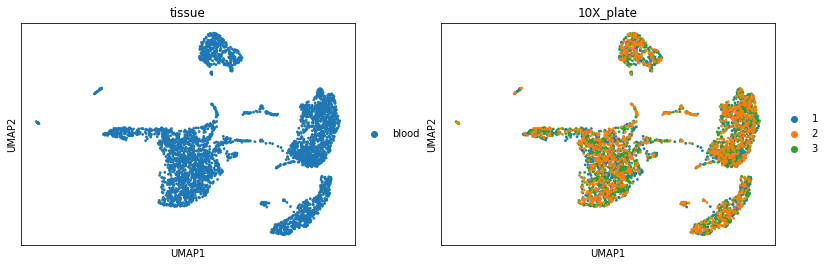

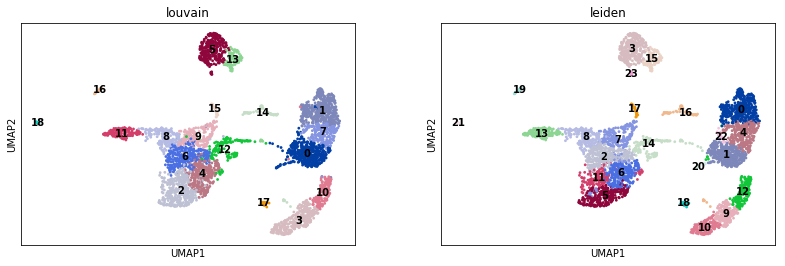

In [74]:
sc.pl.umap(adata, color=['tissue','10X_plate'])
sc.pl.umap(adata, color=['louvain','leiden'], legend_loc='on data')

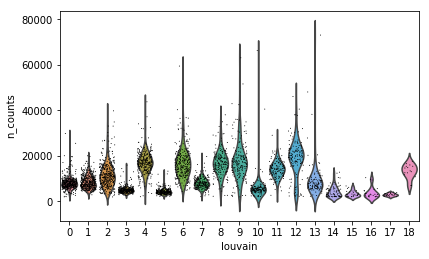

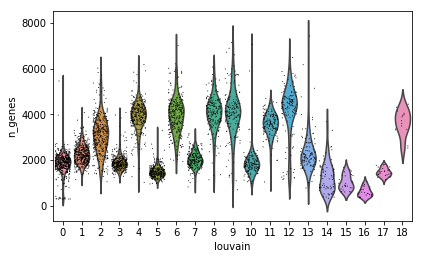

In [75]:
sc.pl.violin(adata, ['n_counts'],jitter=0.4, groupby='louvain')
sc.pl.violin(adata, ['n_genes'],jitter=0.4, groupby='louvain')

Using the wilcoxon rank test we can compute the marker genes for each of the 45 global clusters

In [76]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

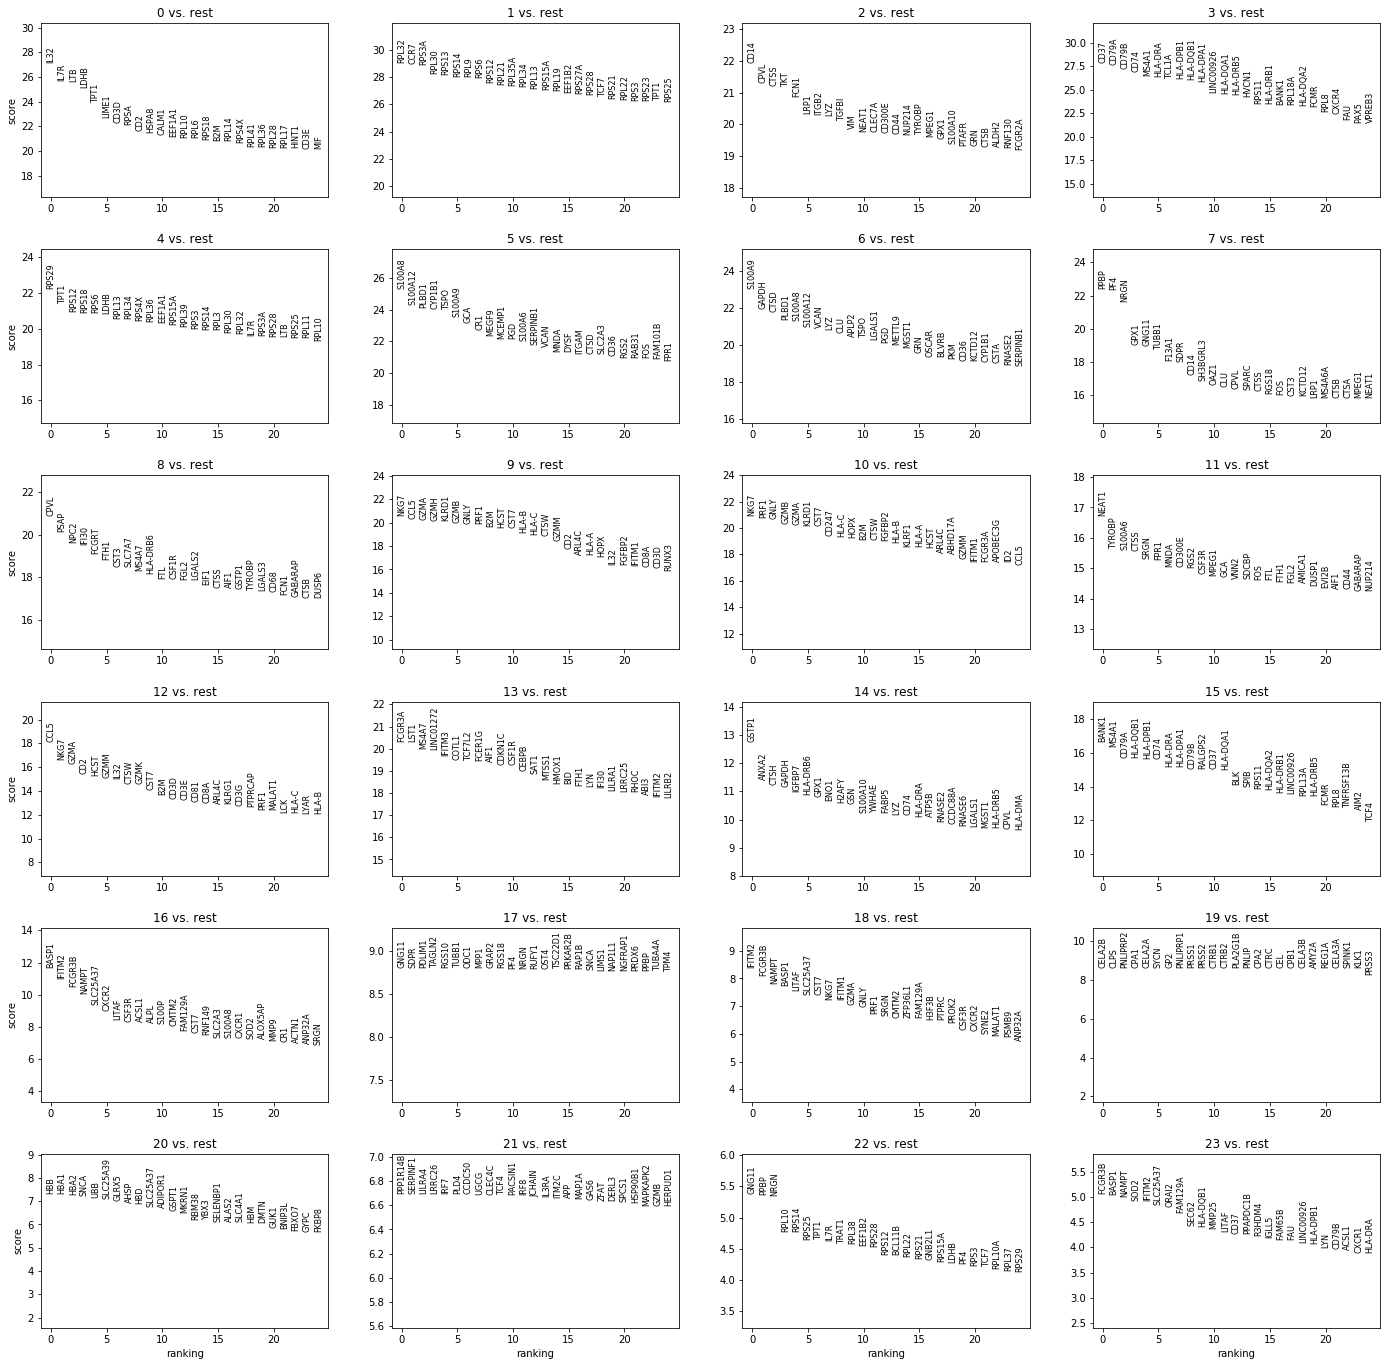

In [77]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [78]:
sapiens_rank_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
# sapiens_rank_genes.to_csv('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-global-rank-genes.csv')
sapiens_rank_genes.head(50)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,IL32,RPL32,CD14,CD37,RPS29,S100A8,S100A9,PPBP,CPVL,NKG7,...,GSTP1,BANK1,BASP1,GNG11,IFITM2,CELA2B,HBB,PPP1R14B,GNG11,FCGR3B
1,IL7R,CCR7,CPVL,CD79A,TPT1,S100A12,GAPDH,PF4,PSAP,CCL5,...,ANXA2,MS4A1,IFITM2,SDPR,FCGR3B,CLPS,HBA1,SERPINF1,PPBP,BASP1
2,LTB,RPS3A,CTSS,CD79B,RPS12,PLBD1,CTSD,NRGN,NPC2,GZMA,...,CTSH,CD79A,FCGR3B,PDLIM1,NAMPT,PNLIPRP2,HBA2,LILRA4,NRGN,NAMPT
3,LDHB,RPL30,TKT,CD74,RPS18,CYP1B1,PLBD1,GPX1,IFI30,GZMH,...,GAPDH,HLA-DQB1,NAMPT,TAGLN2,BASP1,CPA1,SNCA,LRRC26,RPL10,SOD2
4,TPT1,RPS13,FCN1,MS4A1,RPS6,TSPO,S100A8,GNG11,FCGRT,KLRD1,...,IGFBP7,HLA-DPB1,SLC25A37,RGS10,LITAF,CELA2A,UBB,IRF7,RPS14,IFITM2
5,LIME1,RPS14,LRP1,HLA-DRA,LDHB,S100A9,S100A12,TUBB1,FTH1,GZMB,...,HLA-DRB6,CD74,CXCR2,TUBB1,SLC25A37,SYCN,SLC25A39,PLD4,RPS25,SLC25A37
6,CD3D,RPL9,ITGB2,TCL1A,RPL13,GCA,VCAN,F13A1,CST3,GNLY,...,GPX1,HLA-DRA,LITAF,ODC1,CST7,GP2,GLRX5,CCDC50,TPT1,ORAI2
7,RPSA,RPS6,LYZ,HLA-DPB1,RPL34,CR1,LYZ,SDPR,SLC7A7,PRF1,...,ENO1,HLA-DPA1,CSF3R,MPP1,NKG7,PNLIPRP1,AHSP,UGCG,IL7R,FAM129A
8,CD2,RPS12,TGFBI,HLA-DQB1,RPS4X,MEGF9,CLU,CD14,MS4A7,B2M,...,H2AFY,CD79B,ACSL1,GRAP2,IFITM1,PRSS1,HBD,CLEC4C,TRAT1,SEC62
9,HSPA8,RPL21,VIM,HLA-DPA1,RPL36,MCEMP1,APLP2,SH3BGRL3,HLA-DRB6,HCST,...,GSN,RALGPS2,ALPL,RGS18,GZMA,PRSS2,SLC25A37,TCF4,RPL38,HLA-DQB1


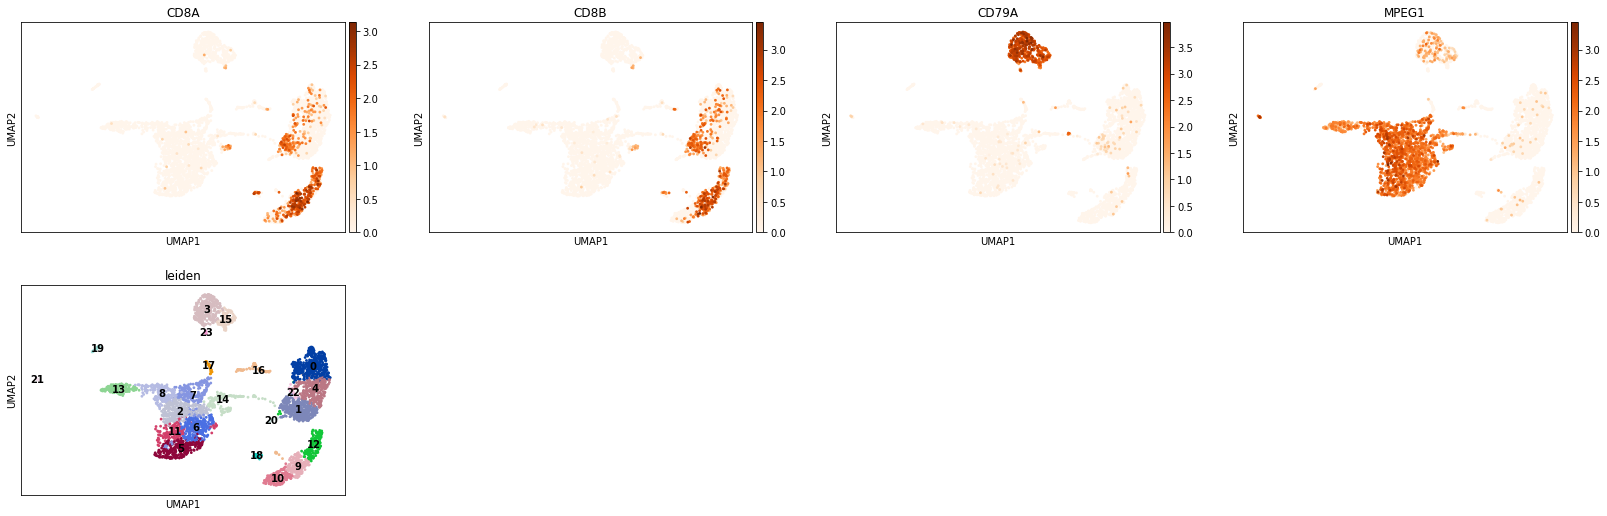

In [81]:
sc.pl.umap(adata,color=['CD8A','CD8B','CD79A','MPEG1','leiden'],legend_loc='on data',cmap='Oranges')


In [ ]:
bladder_louvain_cell_ontology_facs = {}
bladder_louvain_cell_ontology_facs['0'] = 'mast cell (also has basophil marker)' #TPSAB1,TPSB2
bladder_louvain_cell_ontology_facs['1'] = 'endothelial' #PECAM1, VWF, CLDN5
bladder_louvain_cell_ontology_facs['2'] = 'unknown'
bladder_louvain_cell_ontology_facs['3'] = 'fibroblast' #DCN, PDGFRA
bladder_louvain_cell_ontology_facs['4'] = ''
bladder_louvain_cell_ontology_facs[''] = ''
bladder_louvain_cell_ontology_facs[''] = ''
bladder_louvain_cell_ontology_facs

In [ ]:
bladder_leiden_cell_ontology_facs = {}
bladder_leiden_cell_ontology_facs['0'] = 'epithelial' #KRT8, KRT19, CDH1
bladder_leiden_cell_ontology_facs['1'] = 'mast cell (also has basophil marker)' #TPSAB1,TPSB2
bladder_leiden_cell_ontology_facs['2'] = 'endothelial' #PECAM1, VWF, CLDN5
bladder_leiden_cell_ontology_facs['3'] = 'fibroblast' #DCN, PDGFRA
bladder_leiden_cell_ontology_facs['4'] = 'plasma cell' # CD79A, CD27
bladder_leiden_cell_ontology_facs['5'] = 'fibroblast' #DCN, PDGFRA
bladder_leiden_cell_ontology_facs['6'] = 'muscle' # TPM2','MYH11,negative for DCN','PDGFRA
bladder_leiden_cell_ontology_facs['7'] = 'classical monocyte' # CD14
bladder_leiden_cell_ontology_facs['8'] = 'intermediate monocyte' #CD14, FCGR3A
bladder_leiden_cell_ontology_facs['9'] = 'nan' # dead epithelial cells
bladder_leiden_cell_ontology_facs['10'] = 'potential B cell in maturation' #CD27
bladder_leiden_cell_ontology_facs['11'] = 'epithelial' #CDH1, KRTs
bladder_leiden_cell_ontology_facs['12'] = 'lymphatic endothelial' #LYVE1, CLDN5
bladder_leiden_cell_ontology_facs['13'] = 'fibroblst' #positve for DCN','PDGFRA',negative for'ACTA2','TPM2
bladder_leiden_cell_ontology_facs

Look at different cell types. The idea is to subcluster based on the global cell 

In [ ]:
bladder_epithelial = adata(adata.obs['leiden'].isin(['0','11']))

In [142]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
sapiens_rank_genes_scores = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores','pvals']})
# sapiens_rank_genes_scores.to_csv('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-global-rank-genes-scores.csv')
sapiens_rank_genes_scores.head(25)

,0_n,0_s,0_p,1_n,1_s,1_p,2_n,2_s,2_p,3_n,...,10_p,11_n,11_s,11_p,12_n,12_s,12_p,13_n,13_s,13_p
0,C3,12.194760,3.314774e-34,TPSB2,13.747424,5.277543e-43,FCGR2A,13.157047,1.550263e-39,MZB1,...,1.775343e-21,ERCC-00130,6.778328,1.215743e-11,MGP,6.263038,3.775494e-10,SSR4,7.022621,2.177442e-12
1,CFD,12.135195,6.874642e-34,TPSAB1,13.746815,5.322165e-43,AIF1,13.027274,8.561157e-39,DERL3,...,6.395345e-21,ERCC-00074,6.149377,7.778806e-10,DCN,5.796993,6.751468e-09,TMBIM6,5.765114,8.160256e-09
2,DCN,11.890312,1.329082e-32,CPA3,13.551241,7.790180e-42,CYBB,12.997116,1.270449e-38,HERPUD1,...,7.138396e-21,ERCC-00096,5.110495,3.213167e-07,FBLN1,5.389662,7.059038e-08,B2M,5.649535,1.608829e-08
3,MGP,11.856017,2.002775e-32,TPSD1,13.550022,7.920582e-42,ITGB2,12.775040,2.260337e-37,FKBP11,...,1.106547e-20,FYB,4.450074,8.584059e-06,ADH1B,5.338811,9.355809e-08,SPCS1,5.318977,1.043525e-07
4,C1R,11.765766,5.859229e-32,KIT,13.392833,6.659183e-41,TYROBP,12.673902,8.250645e-37,PIM2,...,1.278371e-20,CXCL8,4.199165,2.679011e-05,APOD,5.215616,1.832076e-07,RPLP1,5.153697,2.553995e-07
5,FBLN1,11.722746,9.746082e-32,HPGDS,12.905421,4.195129e-38,MS4A7,12.253205,1.614855e-34,SEC11C,...,1.365919e-20,ERCC-00002,3.939025,8.181346e-05,RPL23A,5.109196,3.235326e-07,PRDM1,5.093019,3.524075e-07
6,COL1A2,11.628584,2.949506e-31,VWA5A,12.882574,5.642174e-38,MS4A6A,12.245589,1.773842e-34,SSR4,...,1.523217e-20,HLA-DRA,3.687696,2.262939e-04,CTSK,5.013261,5.351523e-07,JCHAIN,4.989574,6.051241e-07
7,GPX3,11.578043,5.324778e-31,C1orf186,12.795754,1.731631e-37,CSF1R,12.237364,1.963048e-34,SLAMF7,...,1.535114e-20,TNFRSF1B,3.583220,3.393842e-04,RARRES2,4.764773,1.890659e-06,TMEM59,4.967615,6.778156e-07
8,EFEMP1,11.549765,7.402323e-31,MS4A2,12.741225,3.488730e-37,IFI30,12.155418,5.368639e-34,CD27,...,1.633661e-20,PLEK,3.343220,8.281220e-04,C3,4.760056,1.935398e-06,FKBP11,4.923694,8.492553e-07
9,SERPING1,11.490800,1.467466e-30,ANXA1,12.714113,4.936803e-37,FCER1G,12.047579,1.997316e-33,HSP90B1,...,1.968396e-20,SRGN,3.338185,8.432756e-04,SFRP2,4.673557,2.960281e-06,BIRC3,4.866482,1.136021e-06


Let's look at the overall cycling distribution just for curiosity

In [ ]:
# cell cycle distribution -- using Tirosh et al',' Science 2015
g1s_genes =  ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP',
         'RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2',
         'USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8']

g2m_genes = ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67','TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2',
        'CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','HJURP','CDCA3','HN1','CDC20','TTK','CDC25C','KIF2C',
        'RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3',
        'CBX5','CENPA']


In [ ]:
sc.tl.score_genes_cell_cycle(adata, s_genes=g1s_genes, g2m_genes=g2m_genes)


In [ ]:
adata

In [ ]:
sc.pl.umap(adata,color=['tissue','phase'])

Next we will look at the overall tissue compartments

In [ ]:
# add tissue compartments -- to be added
epithelial_markers = []
stromal_markers = []
immune_markers = []
endothelial_markera = []

# Split the tissues

In [ ]:
adata.obs.groupby(['tissue','10X_plate'])['subjectid'].agg({'ncells pilot':len})#.to_csv('/maca-bulk/sapiens/ncell_pilot.csv')




In [ ]:
adata = read_h5ad('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered.h5ad')
print('tissue','total number of cells')
for t in list(set(adata.obs['tissue'])):
    tiss = adata[adata.obs['tissue']==t]
    print(t,len(tiss))
    tiss.write('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-'+t+'.h5ad')
    

Analyse each tissue individually

In [ ]:
adata_all_tissues = read_h5ad('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered.h5ad')
for t in list(set(adata_all_tissues.obs['tissue'])):
    print(' ')
    print(' ')
    print(' ')
    print(' ')
    print(' ')
    print('Now looking at ' +t+ '!!!')
    print(' ')
    adata = read_h5ad('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-'+t+'.h5ad')
    
    print('make sure data is consistent...')
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    print('get global view of the tissue')
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    
    sc.pl.violin(adata, ['n_genes', 'n_counts'],
             jitter=0.4, multi_panel=True)
    sc.pl.scatter(adata, x='n_counts', y='n_genes')
    
    print('repeat the basic pre-processing')
    adata = adata[adata.obs['n_genes'] < 5000, :]
    adata = adata[adata.obs['n_counts'] > 500, :]
    
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    
    adata.raw = adata
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pp.scale(adata, max_value=10)
    
    print('PCA')
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_overview(adata)
    
    print('neighbors')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
    
    print('visualizations')
    sc.tl.umap(adata)
    sc.tl.tsne(adata)
    
    print('doing Louvain clustering for quick overview but likely to change this into Leiden')
    sc.tl.louvain(adata,resolution=.5)
    
    print('plot')
    sc.pl.tsne(adata, color=['10X_plate','louvain'],cmap='Oranges',ncols=1)
    sc.pl.umap(adata, color=['10X_plate','louvain'],cmap='Oranges',ncols=1)
    
    print('compute tissue rank genes')
    sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
    tiss_rank_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
    tiss_rank_genes.to_csv('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-'+t+'-rank-genes.csv')
    
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    tiss_rank_genes_score = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'scores','pvals']})
    tiss_rank_genes_score.to_csv('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-'+t+'-rank-genes-score.csv')
    print(tiss_rank_genes.head(10))



    